# Running TCAV


This notebook walks you through things you need to run TCAV. In high level, you need:

1. **example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper**: an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator**: an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model



## Requirements

    pip install the tcav and tensorflow packages (or tensorflow-gpu if using GPU)

In [ ]:
import os
import sys

'''
Initial setup
'''
project_id = 'serene-athlete-271523'
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    
    drive.mount("/content/drive")
    os.chdir("/content/drive")

    base_drive = 'Shared drives/TCAV4OCT/'
    
    %tensorflow_version 1.15.2
    import tensorflow as tf
elif not IN_COLAB:
    import tensorflow as tf
    root_dir = '/home/jupyter/tcav_synced/'
    sync_me = True
    # 1. install command: curl https://rclone.org/install.sh | sudo bash
    # 2. follow instructions to set up credentials, use remote login in last step: https://rclone.org/drive/
    #!rclone sync tcav {root_dir} -P
    base_drive = root_dir
    if sync_me:
        !rclone copy {root_dir} tcav:
        print('done safe-syncing from cloud to drive')
        !rclone copy tcav: {root_dir}
        print('done safe-syncing from drive to cloud')
    else:
        print('not syncing')
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    if tf.test.gpu_device_name(): 
        print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
        print(tf.DeviceSpec(device_type="GPU", device_index=34343))
        gpus = True
        strategy = tf.distribute.MirroredStrategy()
    else:
        gpus = False
        print("Not using GPU version of TF")
    #!rclone copy {data_dir} midus:data  -P
    #!rclone copy {results_dir} midus:results -P
os.chdir(base_drive)
try:
  !pip uninstall -y tcav
except:
  print('tcav not installed')
!pip3 install git+https://github.com/schko/tcav.git
# set this to true to run tcav default
default_vars = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
  Cloning https://github.com/schko/tcav.git to /tmp/pip-req-build-oue0qrvw
  Running command git clone -q https://github.com/schko/tcav.git /tmp/pip-req-build-oue0qrvw
  Created wheel for tcav: filename=tcav-0.2.1-cp36-none-any.whl size=38689 sha256=f1711ad2999432da5352314ff4093155b7301010dd7d00a9d21addc0a294e7a0


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import random
tf.VERSION

'1.15.2'

#Step 0. Download images

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 


You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [ ]:
# folder prefix 
prefix = 'playground'

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
# model_to_run = 'GoogleNet'  
user = 'sharath'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = "/tmp/" + user + '/' + project_name
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live. 
source_dir = prefix + "/image_net_subsets/"
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

if default_vars:
  target = 'zebra'
  bottlenecks = ['mixed4c']  # @param 
else:
  target = 'GlaucomaFull'
  bottlenecks = ['flatten_1','dense_1','dense_3']  # @param 
  #bottlenecks = ['mixed_6c']
  concepts = ["arcuates", "red_texture","green_texture","RNFLprob"] #"RNFLprob","VFonly",
  #concepts = ["red_texture", "red_solid", "green_solid", "green_texture"]
  #concepts = ["RGCPprob","RNFLprob","RNFLthickness","RGCPthickness"]
#concepts = ["dotted","striped","zigzagged"]   


## Step 2. Write your model wrapper

Next step is to tell TCAV how to communicate with your model. See `model.GoolgeNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 1. Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2. Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 3. Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 4. Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! I wrote two model wrapers, InceptionV3 and Googlenet.


**sess**: a tensorflow session.

In [ ]:
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
#
if default_vars:
  GRAPH_PATH =  prefix + "/trained_models/google_net_inception_v1/tensorflow_inception_graph.pb"
  LABEL_PATH = prefix + "/trained_models/google_net_inception_v1/imagenet_comp_graph_label_strings.txt"
  mymodel = model.GoolgeNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH, default_vars)
else:
  # Custom
  #GRAPH_PATH =  prefix + "/trained_models/CNNplusFC/CNNplusFC_model.pb"
  #LABEL_PATH = prefix + "/trained_models/CNNplusFC/CNNplusFC_labelStrings.txt"
  #mymodel = model.CNNFC2NetWrapper_public(sess,
  #                                     GRAPH_PATH,
  #                                     LABEL_PATH, default_vars)
  GRAPH_PATH =  prefix + "/trained_models/multiClassModels/inceptionV3multiClass.pb" #denseNet121_5ClassOnlyGlaucomaFeats.pb
  LABEL_PATH = prefix + "/trained_models/multiClassModels/multiClass_labelStrings.txt"
  mymodel = model.inceptionV3multiClassWrapper_public(sess, #denseNetMultiClassWrapper
                                        GRAPH_PATH,
                                        LABEL_PATH, default_vars)
# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...






Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Reshape
BiasAdd
Merge
BiasAdd
BiasAdd
bn_endpoints:  {'inception_v3': <tf.Tensor 'inception_v3/inception_v3/batch_normalization_86/cond/Merge:0' shape=(?, ?, ?, 320) dtype=float32>, 'flatten_1': <tf.Tensor 'inception_v3/flatten_1/Reshape:0' shape=(?, ?) dtype=float32>, 'dense_1': <tf.Tensor 'inception_v3/dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>, 'dropout_1': <tf.Tensor 'inception_v3/dropout_1/cond/Merge:0' shape=(?, 128

## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [ ]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [ ]:
goog=prefix + "/trained_models/multiClassModels/inceptionV3multiClass.pb"
def print_graph_nodes():
  # https://stackoverflow.com/questions/50632258/how-to-restore-tensorflow-model-from-pb-file-in-python
  import tensorflow as tf
  from tensorflow.python.platform import gfile
  GRAPH_PB_PATH = GRAPH_PATH
  with tf.Session() as sess:
    print("load graph")
    with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    print(names)

def load_pb(graphp=GRAPH_PATH):
    with tf.gfile.GFile(graphp, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

#print_graph_nodes()
#graph = load_pb(goog)
#graph = load_pb(GRAPH_PATH)

In [ ]:
def get_rc(additional_rcs = 250):
    rc = ['phones', 'bars', 'hands', 'cheetah print', 'money', 'paper clips', 'mri', 'buildings', 'necklace', 'dosa']
    goog_rc = ['tricycle', 'slug', 'streetcar', 'Eskimo dog', ' patrol wagon', 'lesser panda', ' punching ball', ' chocolate syrup', 'buckle', 
               ' meat cleaver', ' hen of the woods', ' sand bar', 'hatchet', 'magpie', 'valley', ' Galeocerdo cuvieri', ' paddy wagon', 'moped', 
               ' Scottish terrier', 'wombat', ' chow chow', 'microwave', 'mobile home', 'barbell', 'coral reef', 'chime', 'golfcart', 'macaque', 
               ' Dandie Dinmont terrier', 'shield', ' day bed', 'miniature pinscher', ' Maine lobster', 'gar', ' rocker', ' daddy longlegs', 
               ' pay-station', 'lab coat', ' Maltese terrier', ' Ascaphus trui', ' prairie grouse', 'toaster', 'sundial', 'running shoe', 
               'wardrobe', 'bell pepper', ' meatloaf', ' vat', ' offshore rig', 'whippet', ' Ailurus fulgens', ' Alopex lagopus', ' glasshouse', 
               ' all-terrain bike', 'restaurant', ' koala bear', ' megalithic structure', ' mollymawk', ' nappy', 'Scotch terrier', ' blowfish', 
               ' docking facility', 'velvet', ' painter', ' groyne', ' anteater', 'cloak', ' Hylobates syndactylus', 'Tibetan mastiff', 'dragonfly', 
               'butternut squash', 'cello', 'punching bag', 'cardoon', ' mileometer', ' spiny anteater', 'sunscreen', ' mountain lion', ' stop watch', 
               'Dandie Dinmont', 'hammer', 'German short-haired pointer', 'snow leopard', ' Lepisosteus osseus', 'eggnog', ' busby', ' skeeter hawk', 
               'tench', ' leatherback', 'screwdriver', ' Phalangium opilio', 'tank', 'Leonberg', 'snail', 'banjo', 'bookshop', ' duck-billed platypus', 
               'golf ball', 'sleeping bag', 'platypus', 'violin', 'tiger beetle', ' Walker foxhound', 'seat belt', ' sewing needle', ' hankey', 
               'Afghan hound', ' terrace', 'stone wall', 'Angora', ' pipe organ', 'red wine', 'cup', ' laboratory coat', 'Windsor tie', ' high bar', 
               ' monocycle', 'green lizard', ' dish washer', 'orangutan', 'racket', ' bobtail', 'chickadee', ' taper', ' remote', 'apiary', ' tope', 
               'projector', 'frying pan', 'microphone', ' garfish', ' fire truck', 'daisy', ' baseball player', ' board', 'greenhouse', ' Varanus komodoensis', 
               ' Grifola frondosa', 'bassoon', 'toy terrier', ' Dermochelys coriacea', ' ribbed toad', 'gyromitra', 'shovel', 'proboscis monkey', 'hair slide', 
               ' frypan', ' ring mail', ' conker', 'hourglass', 'Loafer', 'caldron', 'pill bottle', ' Homarus americanus', ' penny bank', 'English springer', 
               ' Crotalus adamanteus', ' eating house', 'Old English sheepdog', 'jigsaw puzzle', "potter's wheel", ' chrysanthemum dog', 'pinwheel', 
               'wood rabbit', ' jack', ' armored combat vehicle', ' whiptail lizard', ' carrion fungus', ' Chamaeleo chamaeleon', 'guenon', ' bell', 
               ' sea crawfish', ' ananas', 'dung beetle', ' titi monkey', ' orang', 'stupa', 'bakery', 'French bulldog', ' plectrum', 'croquet ball', 
               ' two-piece', 'fireboat', ' closet', 'stethoscope', 'rifle', 'crutch', 'coyote', 'sorrel', ' trolley', 'mortar', ' crampfish', ' basset hound', 
               'bow', 'harvester', 'container ship', ' howler', 'jeep', ' crawfish', ' Chlamydosaurus kingi', 'komondor', ' U-boat', ' Alaskan king crab', 
               'king crab', 'Walker hound', 'organ', 'leatherback turtle', 'hard disc', ' Tringa totanus', 'reel', 'basset', ' Siamese', ' water ox', 
               ' torpedo', 'wok', ' panda', ' English cocker spaniel', ' Ornithorhynchus anatinus', 'Siamese cat', 'padlock', 'dowitcher', 'candle', 
               'sports car', ' taxi', 'brassiere', ' bookstall', 'Persian cat', ' army tank', ' ring armor', 'howler monkey', 'espresso maker', ' press', 
               'harp', ' dishwashing machine', 'shoji', 'Staffordshire bullterrier', 'chocolate sauce', 'Lhasa', 'cricket', 'sarong', 'crane', 'wig', 
               'wooden spoon', 'hay', ' beam', ' langouste', ' solar furnace', 'studio couch', ' horn', ' white fox', 'hamster', 'schooner', ' guenon monkey', 
               'Irish water spaniel', 'theater curtain', ' velocipede', 'Tibetan terrier', ' Alaska king crab', 'electric locomotive', ' duckbill', 'warplane', 
               ' eating place', ' trike', ' sunblock', 'swab', ' jetty', 'little blue heron', 'beer glass', 'American lobster', ' mole', 'Newfoundland', 
               ' Kakatoe galerita', ' upright piano', 'drilling platform', 'poncho', 'chiton', ' Staffordshire terrier', 'garter snake', 'conch', 
               ' polyplacophore', 'church', ' quill pen', 'solar dish', 'king penguin', 'pug', 'safety pin', 'shower curtain', ' CRT screen', 'rocking chair', 
               ' diamondback rattlesnake', ' pufferfish', ' carriage', ' pencil eraser', ' chain armour', 'maraca', ' Angora rabbit', ' cat bear', ' bakehouse', 
               'jackfruit', 'fire engine', 'meat loaf', ' scope', ' chain armor', ' tabby cat', 'ballplayer', 'bolo tie', ' tractor trailer', ' giant lizard', 
               ' Canis lupus', ' Maltese', 'upright', ' Hypsiglena torquata', ' manufactured home', 'half track', ' Scottie', ' dragon lizard', 'eel', 'dough', 
               'redshank', ' tool kit', 'military uniform', ' tam-tam', 'water snake', ' pig', ' plectron', " carpenter's plane", ' grass snake', 'impala', 
               'lorikeet', 'dishwasher', ' buckler', ' grunter', 'tailed frog', 'whistle', ' alsatian', ' Crotalus cerastes', 'bassinet', 'rock python', 
               'sandbar', ' clumber spaniel', 'viaduct', 'grasshopper', ' Symphalangus syndactylus', 'yawl', 'siamang', 'otter', 'power drill', ' gong', 
               ' squealer', 'library', 'chain', ' Lhasa apso', ' seatbelt', ' bell toad', 'cocker spaniel', 'water buffalo', ' reaper', 'strainer', 
               ' cottontail', ' container vessel', 'consomme', ' Bubalus bubalis', 'French loaf', ' eatery', 'capuchin', ' bra', 'spoonbill', ' red hot', 
               'basketball', 'spider web', 'vizsla', 'chiffonier', 'spotted salamander', 'Sussex spaniel', ' horned rattlesnake', ' Iguana iguana', 
               'steam locomotive', 'shopping cart', 'tiger cat', 'cassette', ' otter hound', ' disc brake', ' mosquito hawk', 'submarine', 'green snake', 
               ' racing car', 'beer bottle', 'jellyfish', ' toilet paper', ' jammies', ' orangutang', 'sea cucumber', 'mongoose', ' race car', 
               ' cottontail rabbit', ' billfish', 'rapeseed', 'assault rifle', ' bullet', 'whiptail', ' Araneus cavaticus', 'hummingbird', 'Polaroid camera', 
               ' Paralithodes camtschatica', ' dockage', 'motor scooter', 'Labrador retriever', ' gray wolf', ' woodworking plane', ' Panthera uncia', 
               'plate rack', ' scooter', ' native bear', ' bathroom tissue', ' hard disk', 'acorn squash', 'cicada', 'frilled lizard', 'lionfish', 'sandal', 
               'sulphur-crested cockatoo', 'minibus', 'cab', 'totem pole', 'hotdog', ' Felis concolor', 'hornbill', 'Weimaraner', 'birdhouse', 'porcupine', 
               'mountain bike', ' groin', 'beaver', 'papillon', ' rubber', 'turnstile', ' bighorn sheep', 'balance beam', ' Cacatua galerita', 'dome', 
               ' hodometer', 'lakeside', ' Turdus migratorius', ' Tinca tinca', ' rock lobster', 'stove', 'sidewinder', 'Shih-Tzu', 'night snake', 
               ' microwave oven', 'horizontal bar', 'Boston bull', 'electric ray', 'volleyball', 'ski mask', ' armoured combat vehicle', ' chopper', 
               'pillow', 'hen-of-the-woods', 'spaghetti squash', 'timber wolf', 'rotisserie', 'soft-coated wheaten terrier', ' polar bear', 'snowplow', 
               ' punchball', 'pot', ' Rocky Mountain bighorn', ' coach', ' ringtail', ' fixed disk', 'German shepherd', 'black swan', 
               'American Staffordshire terrier', ' Mergus serrator', 'paper towel', ' darning needle', ' duckbilled platypus', ' cocker', 'handkerchief', 
               'echidna', 'pay-phone', ' meat market', 'amphibian', 'loupe', 'barn', ' German police dog', ' mop', 'bucket', ' radio reflector', 'mixing bowl', 
               ' cimarron', ' police wagon', 'parachute', ' carabid beetle', " spider's web", ' pyjama', 'patio', ' off-roader', ' punch bag', ' bee house', 
               ' Ambystoma maculatum', 'puffer', ' golf cart', 'hog', 'goblet', ' mike', ' box tortoise', 'radio telescope', 'soccer ball', ' puma', ' vale', 
               ' containership', 'Border collie', ' Rocky Mountain sheep', ' pit bull terrier', ' Saimiri sciureus', ' flowerpot', 'triumphal arch', 
               'rubber eraser', ' articulated lorry', ' swob', 'mousetrap', 'tiger shark', ' wax light', 'water tower', ' Triturus vulgaris', ' shako', 
               'African chameleon', 'police van', 'screen', 'whiskey jug', 'Maltese dog', ' bola tie', 'brain coral', 'ice bear', 'pajama', ' Hungarian pointer', 
               ' Polaroid Land camera', 'dining table', ' hanky', ' bakeshop', 'piggy bank', 'photocopier', ' shoe store', 'stopwatch', 'chain mail', 'megalith', 
               ' Polyporus frondosus', ' Python sebae', 'sewing machine', 'face powder', 'common newt', 'bib', 'guillotine', 'prison', ' iguana', 'shoe shop', 
               'bullet train', 'cheeseburger', ' napkin', ' CRO', ' Afghan', 'iron', 'fiddler crab', ' trolley car', 'Petri dish', ' Pongo pygmaeus', 
               ' Nasalis larvatus', " jeweler's loupe", 'syringe', 'diaper', ' dishcloth', ' snake doctor', 'toilet tissue', ' roach', ' globefish', 
               ' hankie', 'bolete', 'ski', 'space heater', 'Siberian husky', 'disk brake', 'modem', ' cicala', ' bola', ' lakeshore', 'Japanese spaniel', 
               ' prairie fowl', ' fiddle', 'marimba', 'langur', ' Alaska crab', ' grey wolf', ' black Maria', ' prairie wolf', 'isopod', 'broom', 'French horn', 
               'kite', ' amphibious vehicle', 'plane', ' kangaroo bear', 'bikini', ' bolo', 'stage', 'bearskin', ' snowplough', ' jak', 'sombrero', 'prairie chicken', 
               'jay', ' Boston terrier', 'chow', ' snake feeder', ' hot dog', ' American pit bull terrier', ' Canis latrans', " devil's darning needle", 
               ' Asiatic buffalo', ' Northern lobster', ' Egretta caerulea', 'cockroach', ' Komodo lizard', 'red-breasted merganser', 'koala', 'weasel', ' seawall', 
               'otterhound', 'cuirass', 'harvestman', 'cannon', 'diamondback', ' garpike', ' church building', ' courgette', ' Phascolarctos cinereus', 
               ' Staffordshire bull terrier', 'catamaran', ' holothurian', 'Chesapeake Bay retriever', ' leathery turtle', 'cowboy boot', 'Christmas stocking', 
               'castle', ' Ursus Maritimus', 'bittern', ' pizza pie', 'Arctic fox', 'Rhodesian ridgeback', ' mail', ' wagon', 'nipple', 'ping-pong ball', 
               ' Aptenodytes patagonica', ' landrover', 'snowmobile', ' cathode-ray oscilloscope', ' nursery', 'macaw', ' red panda', 'cassette player', 'table lamp', 
               'bannister', 'wine bottle', ' panther', ' husky', 'zucchini', 'space bar', 'odometer', ' commode', 'stingray', ' Newfoundland dog', ' crayfish', 
               ' rock snake', " pj's", 'oil filter', 'tub', 'ground beetle', 'butcher shop', ' tramcar', 'pelican', ' brush wolf', 'stinkhorn', ' numbfish', 
               ' hockey puck', ' assault gun', 'albatross', 'folding chair', 'purse', 'kuvasz', ' cauldron', 'pizza', 'titi', ' horse chestnut', ' Aepyceros melampus', 
               'malinois', 'puck', 'spiny lobster', 'green mamba', 'Komodo dragon', 'magnetic compass', 'quill', 'breakwater', ' sun blocker', ' hack', 
               'Gordon setter', ' xylophone', ' smoothing iron', ' Ovis canadensis', ' trucking rig', ' pail', 'giant schnauzer', 'oscilloscope', 'gong', ' sea cradle', 
               ' coat-of-mail shell', 'airliner', 'common iguana', ' tailed toad', ' rig', ' English springer spaniel', ' tram', 'EntleBucher', 'dishrag', 'pineapple', 
               ' military plane', ' Cebus capucinus', ' ring armour', 'clumber', 'unicycle', "carpenter's kit", 'squirrel monkey', 'packet', ' German shepherd dog', 
               ' ounce', 'boxer', 'buckeye', ' taxicab', 'bighorn', 'abacus', 'hamper', 'quail', 'tabby', 'armadillo', ' pug-dog', 'trailer truck', ' prison house', 
               ' sport car', ' Thalarctos maritimus', ' milometer', ' chute', 'pier', 'pick', ' bulwark', 'bluetick', 'pole', 'espresso', ' catamount', ' violoncello', 
               'remote control', 'park bench', 'cougar', 'robin', 'tripod', 'racer', ' semi', ' skillet', 'pretzel', 'barn spider', 'dock', 'box turtle', ' pigboat', 
               ' racquet', ' bear cat', 'redbone', 'altar', 'llama', ' hedgehog', ' Sus scrofa', ' solar collector', ' American robin', 'spindle', ' bandeau', 
               ' hopper', 'cleaver', ' bookstore', 'passenger car', 'leafhopper', ' shoe-shop', ' theatre curtain', 'tick', ' Cygnus atratus', 'barometer', ' sub', 
               ' Lacerta viridis', 'dumbbell']
    rc.extend(random.sample(goog_rc, additional_rcs))
    return rc

In [ ]:
import pickle
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)
rc = ['phones', 'bars', 'hands', 'cheetah print', 'money', 'paper clips', 'mri', 'buildings', 'necklace', 'dosa']
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   random_concepts = rc) #get_rc(10))
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=True, num_workers=5)


with open('result.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ('done!')


This may take a while... Go get coffee!
params num:  390
Finished running param 100 of 390
Finished running param 200 of 390
Finished running param 300 of 390
done!


In [ ]:
import pickle
results = pickle.load( open( "result.pickle", "rb" ) )

Class = GlaucomaFull
  Concept = arcuates
random_i_ups[bottleneck]:  [0.7368421052631579, 0.07894736842105263, 0.7105263157894737, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.05263157894736842, 0.7368421052631579, 0.7631578947368421, 0.13157894736842105, 0.10526315789473684, 0.07894736842105263, 0.7631578947368421, 0.07894736842105263, 0.07894736842105263, 0.05263157894736842, 0.07894736842105263, 0.7631578947368421, 0.07894736842105263, 0.7368421052631579, 0.7105263157894737, 0.7368421052631579, 0.7631578947368421, 0.07894736842105263, 0.7368421052631579, 0.7368421052631579, 0.10526315789473684, 0.7631578947368421, 0.7894736842105263, 0.10526315789473684, 0.7894736842105263, 0.7368421052631579, 0.07894736842105263, 0.7894736842105263, 0.07894736842105263, 0.7631578947368421, 0.10526315789473684, 0.7368421052631579, 0.07894736842105263, 0.05263157894736842, 0.7368421052631579, 0.07894736842105263, 0.7105263157894737, 0.7368421052631579, 0.7894736842105263, 0.105263157

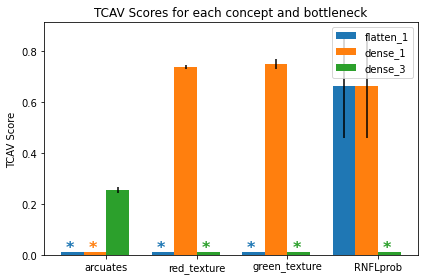

In [ ]:
# print(results)
# our output
utils_plot.plot_results(results, num_random_exp=10, random_concepts=rc)

In [ ]:
started at ~1:50